In [ ]:
!mkdir -p /content/embalses


# Análisis de embalses de la Comunidad de Madrid (Big Data Analysis)

En este notebook analizamos los datos históricos de agua embalsada en varios embalses
de la Comunidad de Madrid. El objetivo es:

- Ingerir todos los ficheros CSV en una sola ejecución.
- Limpiar y transformar los datos para obtener:
  - Un *dataframe completo* con todos los embalses.
  - Una *lista/diccionario de dataframes* por embalse.
- Visualizar los datos mediante:
  - Gráfico de barras por año de todos los embalses.
  - Gráfico de barras por año de un embalse concreto.
  - Gráfico de puntos (scatter) comparando dos embalses.
  - Violin Plot mostrando por año la cantidad de agua embalsada.
- Aplicar el algoritmo de predicción **Prophet** para estimar qué ocurrirá
  en los próximos 12 meses.




In [ ]:
# Importamos las librerías básicas que usaremos en todo el notebook

import os                 # Para trabajar con rutas de ficheros
import glob               # Para buscar todos los CSV de una carpeta
import pandas as pd       # Librería principal para manejar datos en forma de tablas (dataframes)
import numpy as np        # Librería de soporte numérico

import matplotlib.pyplot as plt  # Para hacer gráficos básicos
import seaborn as sns            # Para gráficos estadísticos más avanzados

# Configuramos algunos parámetros gráficos para que los plots se vean mejor
plt.style.use("seaborn-v0_8")  # Estilo visual agradable
sns.set()                      # Activamos configuración por defecto de seaborn

# los gráficos se muestren dentro del notebook
%matplotlib inline


## Cargar todos los ficheros CSV de los embalses

En esta celda definimos la ruta donde hemos guardado los CSV en Google Colab.

Opciones habituales:
- Subir los ficheros manualmente a `/content/embalses`
- O montarlos desde Google Drive.

El objetivo de esta parte es:
- Definir una ruta base.
- Listar todos los ficheros `.csv` que haya en esa carpeta para procesarlos automáticamente.


In [ ]:


base_folder = "/content/embalses"

# Obtenemos la lista de todos los ficheros .csv dentro de esa carpeta
csv_files = glob.glob(os.path.join(base_folder, "*.csv"))

print("Número de ficheros encontrados:", len(csv_files))
print("Ejemplo de rutas encontradas:")
for path in csv_files[:5]:  # Mostramos solo los primeros 5
    print(" -", os.path.basename(path))




Número de ficheros encontrados: 14
Ejemplo de rutas encontradas:
 - AguaEmbalsada_RioLozoya_Riosequillo.csv
 - AguaEmbalsada_RioLozoya_LaPinilla.csv
 - AguaEmbalsada_RioGuadalix_Pedrezuela.csv
 - AguaEmbalsada_RioLozoya_PuentesViejas.csv
 - AguaEmbalsada_RioManzanares_Navacerrada.csv


## Función de ingesta y limpieza de un CSV de embalse

Los ficheros tienen un formato similar:
- Columna `anio` (año), pero a veces solo aparece en la primera fila de cada año.
- Columna `mes` con nombres en español (enero, febrero, ...).
- Columna `hec_cub` con el volumen de agua embalsada (hectómetros cúbicos),
  usando coma `,` como separador decimal.

Además, algunos ficheros:
- Tienen un pequeño problema de codificación (BOM o caracteres especiales).
- Contienen filas de texto al final (notas – “Fuente: Canal de Isabel II”, etc.).

La función `cargar_embalse_csv` hará todo esto:
1. Leer el CSV con el separador correcto `;`.
2. Corregir posibles problemas de codificación.
3. Seleccionar solo las columnas necesarias (`anio`, `mes`, `hec_cub`).
4. Rellenar los años que faltan (forward fill).
5. Convertir meses en números (1–12).
6. Convertir `hec_cub` a número flotante en formato inglés (punto decimal).
7. Eliminar filas que no son datos válidos.
8. Añadir columnas derivadas:
   - `rio` (nombre del río a partir del nombre del fichero).
   - `embalse` (nombre del embalse a partir del nombre del fichero).
   - `fecha` (primer día de cada mes).

El resultado será un **dataframe limpio** con una fila por mes.


In [ ]:
# Diccionario para convertir el nombre del mes (en español) a número de mes
month_map = {
    "enero": 1,
    "febrero": 2,
    "marzo": 3,
    "abril": 4,
    "mayo": 5,
    "junio": 6,
    "julio": 7,
    "agosto": 8,
    "septiembre": 9,
    "setiembre": 9,
    "octubre": 10,
    "noviembre": 11,
    "diciembre": 12,
}

def cargar_embalse_csv(path_csv: str) -> pd.DataFrame:
    """
    Lee un fichero CSV de embalse y devuelve un dataframe limpio con:
    anio, mes, hec_cub, month_num, rio, embalse, fecha
    """

    # 1) Intentamos leer el CSV con el separador ';'
    try:
        raw = pd.read_csv(path_csv, sep=";")
    except UnicodeDecodeError:
        # Si hay un problema de codificación, probamos con latin1
        raw = pd.read_csv(path_csv, sep=";", encoding="latin1")

    # 2) A veces la columna 'anio' viene con un BOM raro (ï»¿anio)
    first_col = raw.columns[0]
    if "anio" in first_col:
        raw = raw.rename(columns={first_col: "anio"})

    # 3) Nos quedamos solo con las columnas que vamos a usar
    df = raw[["anio", "mes", "hec_cub"]].copy()

    # 4) Convertimos 'anio' a numérico y rellenamos los NaN hacia arriba (forward fill)
    df["anio"] = pd.to_numeric(df["anio"], errors="coerce")
    df["anio"] = df["anio"].ffill()  # rellena los valores vacíos con el último año conocido

    # 5) Normalizamos el texto de los meses (minúsculas, sin espacios)
    df["mes"] = df["mes"].astype(str).str.strip().str.lower()

    # 6) Mapeamos el mes a su número (1-12)
    df["month_num"] = df["mes"].map(month_map)

    # 7) Limpiamos la columna hec_cub:
    #    - quitamos espacios
    #    - cambiamos coma por punto
    df["hec_cub"] = df["hec_cub"].astype(str).str.strip()
    df = df[df["hec_cub"].str.len() > 0]  # quitamos filas vacías
    df["hec_cub"] = df["hec_cub"].str.replace(".", "", regex=False)  # por si fueran separadores de miles
    df["hec_cub"] = df["hec_cub"].str.replace(",", ".", regex=False)  # convertimos coma en punto
    df["hec_cub"] = pd.to_numeric(df["hec_cub"], errors="coerce")

    # 8) Eliminamos filas donde falte año, mes o hec_cub
    df = df.dropna(subset=["anio", "month_num", "hec_cub"])

    # 9) Añadimos columnas 'rio' y 'embalse' a partir del nombre del fichero
    base_name = os.path.basename(path_csv).replace(".csv", "")
    parts = base_name.split("_")

    # El patrón es algo como: AguaEmbalsada_RioLozoya_ElAtazar
    rio = parts[1] if len(parts) > 1 else None
    embalse = parts[2] if len(parts) > 2 else None

    df["rio"] = rio
    df["embalse"] = embalse

    # 10) Creamos una columna de fecha (primer día de cada mes)
    df["fecha"] = pd.to_datetime(
        dict(
            year=df["anio"].astype(int),
            month=df["month_num"].astype(int),
            day=1,
        )
    )

    return df


## Ingesta de todos los datasets en una sola ejecución

En esta celda vamos a:
- Aplicar la función `cargar_embalse_csv` a TODOS los ficheros `.csv` encontrados.
- Guardar:
  - Un **dataframe completo** (`df_completo`) con todos los embalses concatenados.
  - Un **diccionario de dataframes** `embalses_dict` donde la clave es el nombre
    del embalse y el valor es su dataframe individual.




In [ ]:
dataframes_embalses = []   # lista con dataframes de cada embalse
embalses_dict = {}         # diccionario embalse -> dataframe

for path in csv_files:
    df_embalse = cargar_embalse_csv(path)
    dataframes_embalses.append(df_embalse)

    # guardamos también en un diccionario por nombre de embalse
    nombre_embalse = df_embalse["embalse"].iloc[0]
    embalses_dict[nombre_embalse] = df_embalse

# Concatenamos todos en un dataframe completo
df_completo = pd.concat(dataframes_embalses, ignore_index=True)

print("Filas totales en el dataframe completo:", len(df_completo))
print("Columnas:", df_completo.columns.tolist())
print("\nEmbalses encontrados:", sorted(embalses_dict.keys()))

# Mostramos las primeras filas para verificar
df_completo.head()


Filas totales en el dataframe completo: 3876
Columnas: ['anio', 'mes', 'hec_cub', 'month_num', 'rio', 'embalse', 'fecha']

Embalses encontrados: ['ElAtazar', 'ElVado', 'ElVillar', 'LaAcena', 'LaJorosa', 'LaPinilla', 'LosMorales', 'Navacerrada', 'Navalmedio', 'Pedrezuela', 'PuentesViejas', 'Riosequillo', 'Santillana', 'Valmayor']


,anio,mes,hec_cub,month_num,rio,embalse,fecha
0,1998.0,enero,45.782,1.0,RioLozoya,Riosequillo,1998-01-01
1,1998.0,febrero,46.640,2.0,RioLozoya,Riosequillo,1998-02-01
2,1998.0,marzo,45.965,3.0,RioLozoya,Riosequillo,1998-03-01
3,1998.0,abril,46.209,4.0,RioLozoya,Riosequillo,1998-04-01
4,1998.0,mayo,43.954,5.0,RioLozoya,Riosequillo,1998-05-01


## Exploración rápida del dataframe completo

En esta sección comprobamos:
- El número de filas y columnas.
- El tipo de datos de cada columna.
- Un resumen estadístico de `hec_cub`.

Esto sirve como **validación de la ingesta y transformación**, y responde al
punto del enunciado sobre la “visualización del dataframe ingestadо”
(y también forma parte de una primera visión del dataset).


In [ ]:
# Información general del dataframe
print("Información del dataframe completo:")
df_completo.info()

print("\nResumen estadístico de la columna hec_cub (agua embalsada):")
display(df_completo["hec_cub"].describe())

# Comprobamos los rangos de años
print("\nAños disponibles en los datos:", int(df_completo["anio"].min()), "–", int(df_completo["anio"].max()))


Información del dataframe completo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3876 entries, 0 to 3875
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   anio       3876 non-null   float64       
 1   mes        3876 non-null   object        
 2   hec_cub    3876 non-null   float64       
 3   month_num  3876 non-null   float64       
 4   rio        3876 non-null   object        
 5   embalse    3876 non-null   object        
 6   fecha      3876 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 212.1+ KB

Resumen estadístico de la columna hec_cub (agua embalsada):


,hec_cub
count,3876.000000
mean,47.720440
std,80.207739
min,0.000000
25%,6.232750
50%,22.324000
75%,44.131000
max,423.885000



Años disponibles en los datos: 1998 – 2021


## Gráfico de barras por año de todos los embalses

Objetivo: construir un gráfico de barras donde:
- El eje X sea el año (`anio`).
- El eje Y sea el volumen medio anual de agua embalsada (`hec_cub`).
- Cada embalse aparezca como una serie diferente (varias barras por año).

Pasos:
1. Agrupar por `anio` y `embalse` calculando la media de `hec_cub` en cada año.
2. Pasar el resultado a formato de tabla (pivot) para que cada embalse sea una columna.
3. Dibujar un gráfico de barras con `pandas/matplotlib`.

Este gráfico responde al requisito:
> "Gráfico de barras por año de todos los embalses".


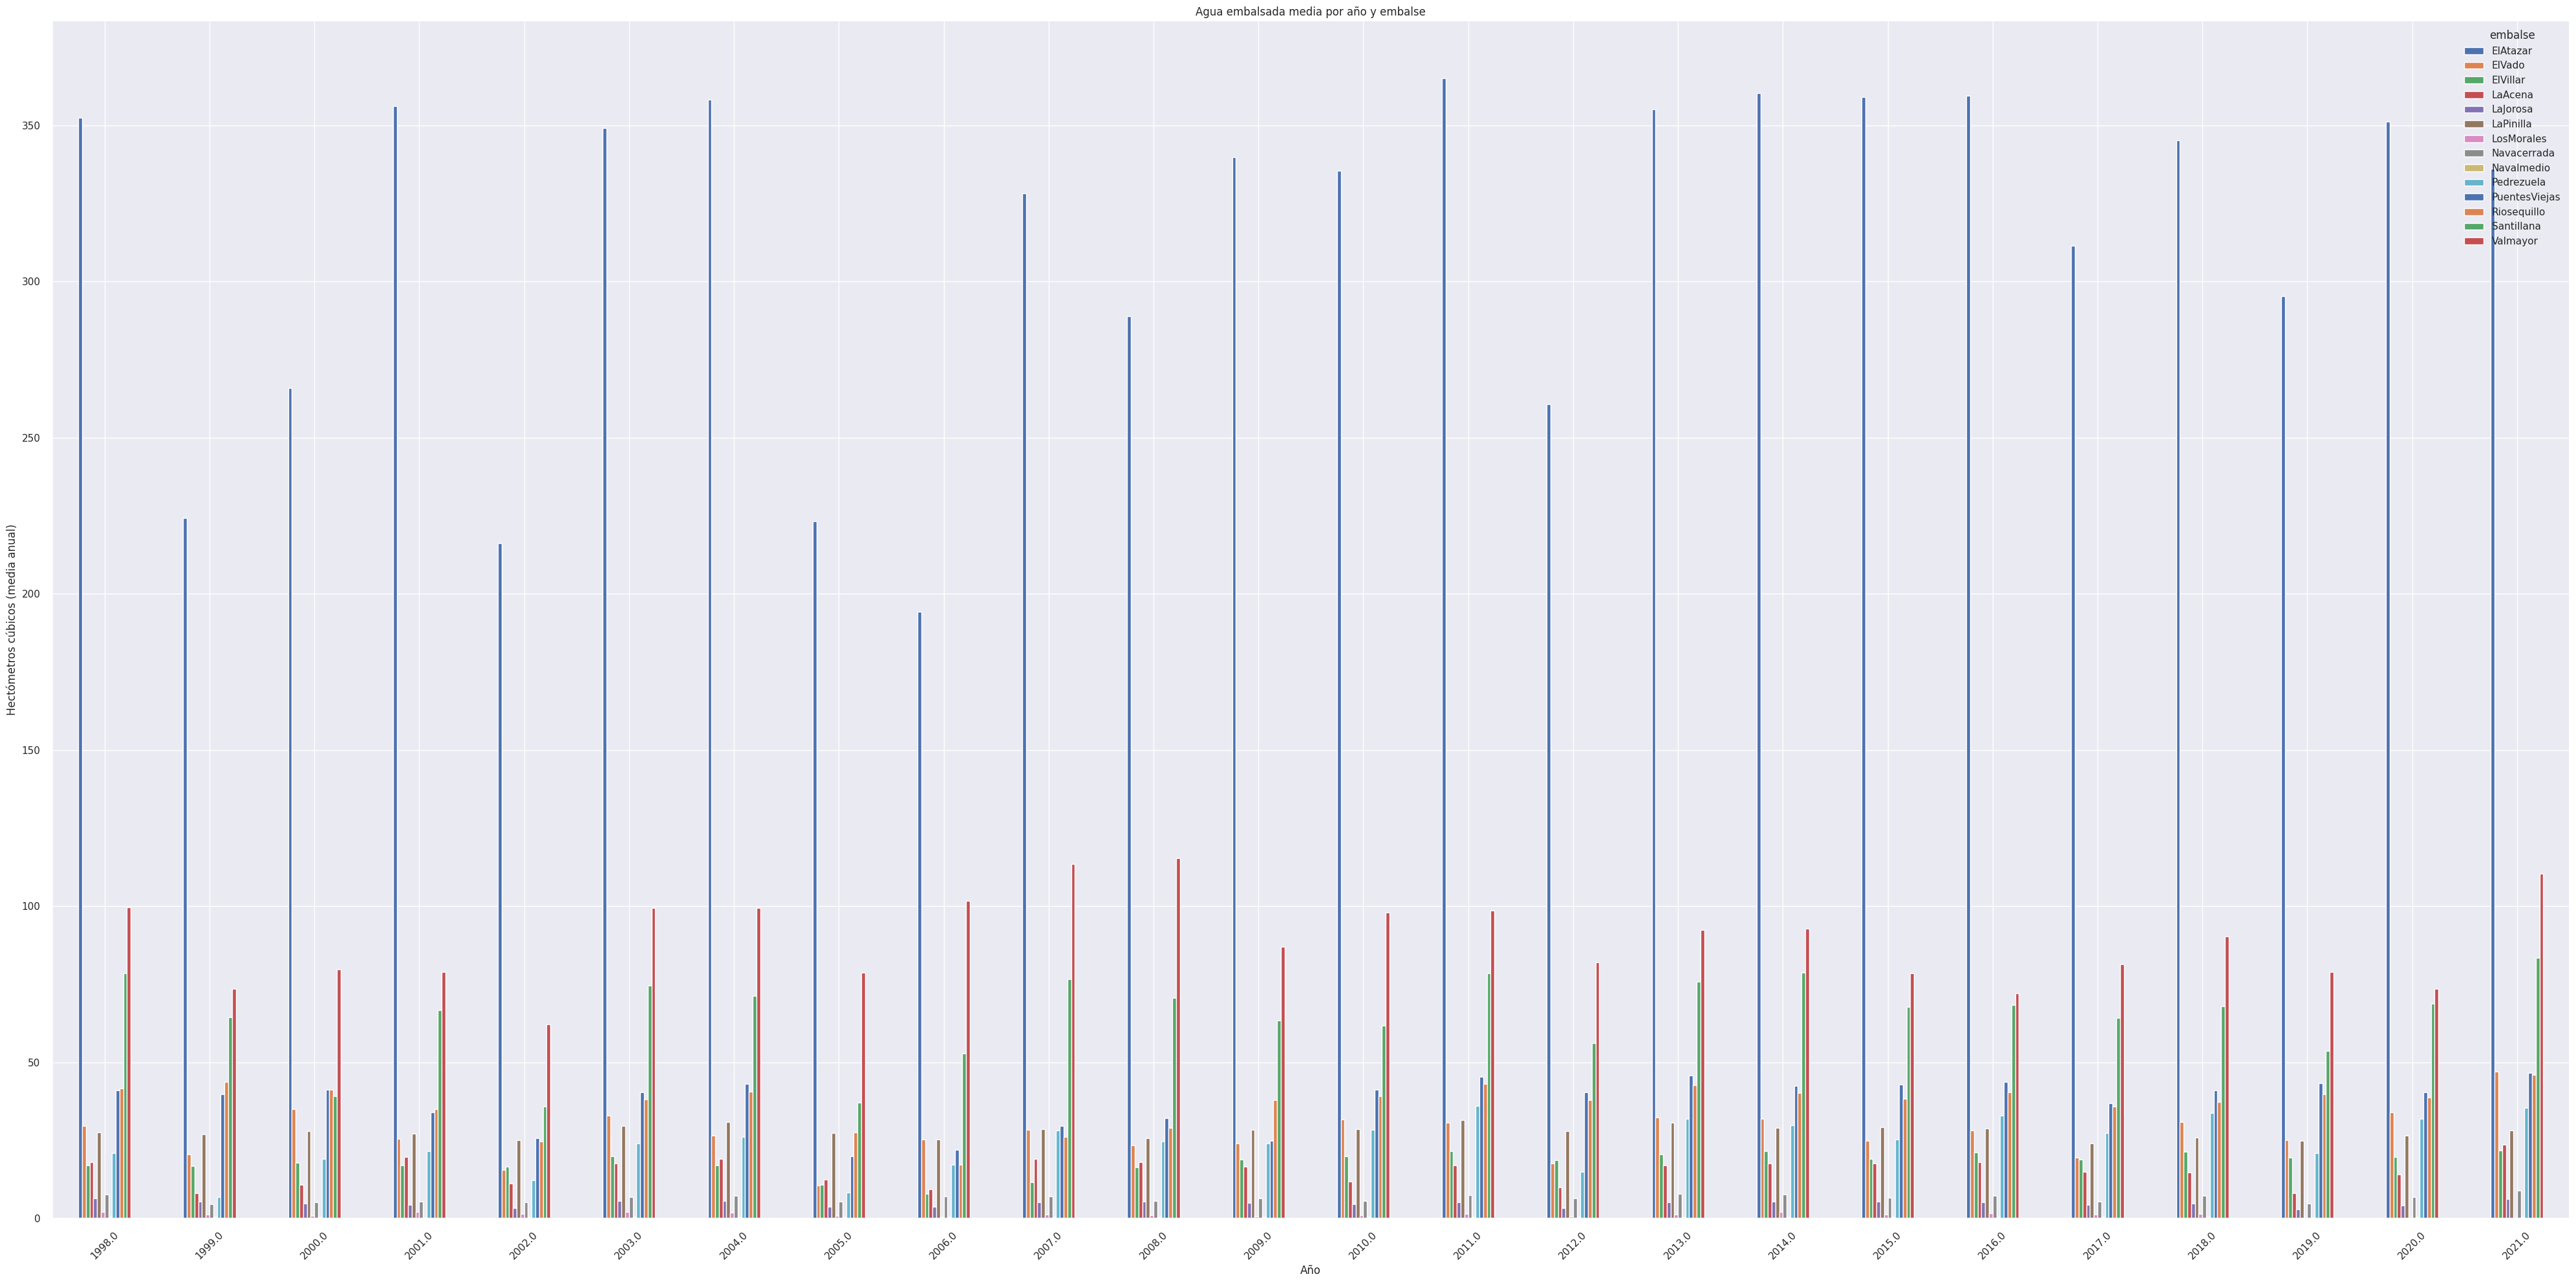

In [ ]:
# 1) Agrupamos por año y embalse, calculando la media de hec_cub
df_anual_embalse = (
    df_completo
    .groupby(["anio", "embalse"])["hec_cub"]
    .mean()
    .reset_index()
)

# 2) Creamos una tabla donde:
#    - índice: año
#    - columnas: embalses
#    - valores: hec_cub medio anual
tabla_anual = df_anual_embalse.pivot(index="anio", columns="embalse", values="hec_cub")

# 3) Dibujamos el gráfico de barras
ax = tabla_anual.plot(kind="bar", figsize=(40, 20))
ax.set_title("Agua embalsada media por año y embalse")
ax.set_xlabel("Año")
ax.set_ylabel("Hectómetros cúbicos (media anual)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Gráfico de barras por año de cada embalse

Además del gráfico conjunto, es útil ver un embalse de forma individual.

En esta celda:
- Definimos una función que recibe el nombre de un embalse.
- Calcula la media anual de `hec_cub` para ese embalse.
- Dibuja un gráfico de barras sencillo año vs. volumen.

Así podemos evaluar si algún embalse muestra un patrón claramente descendente,
lo que podría ser una señal de riesgo de sequía localizada.

Esto se relaciona con:
> "Gráfico de barras por año de cada uno los embalses"


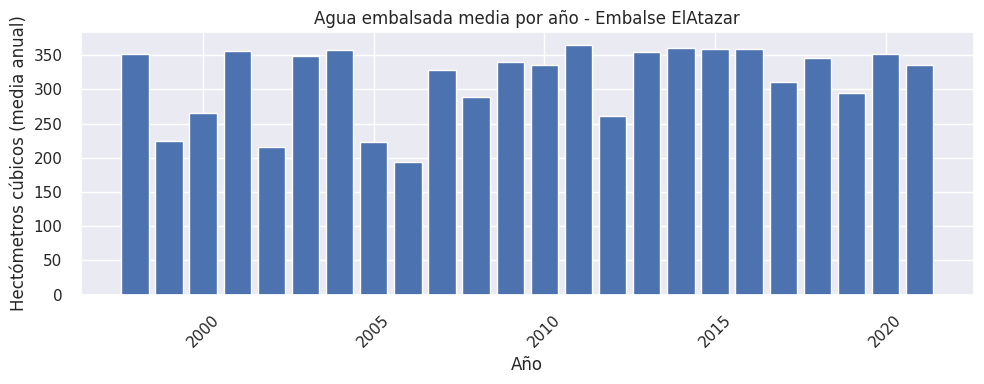

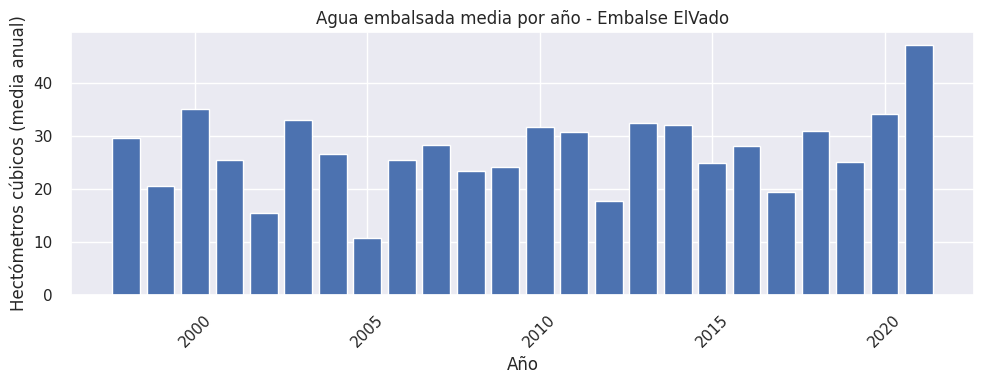

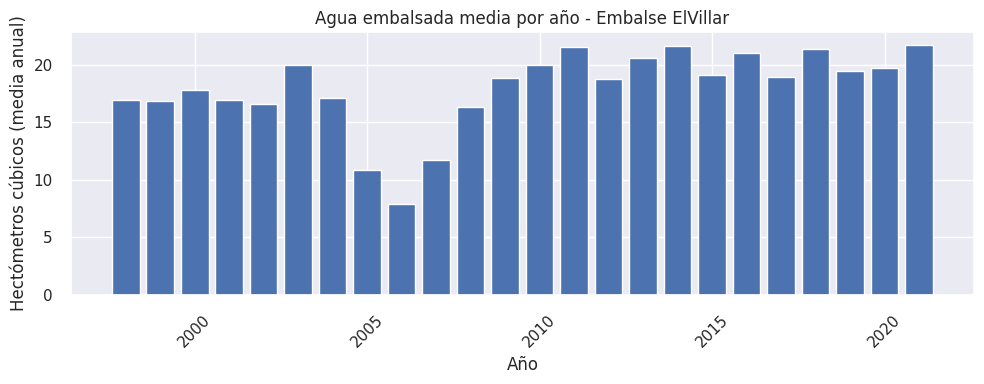

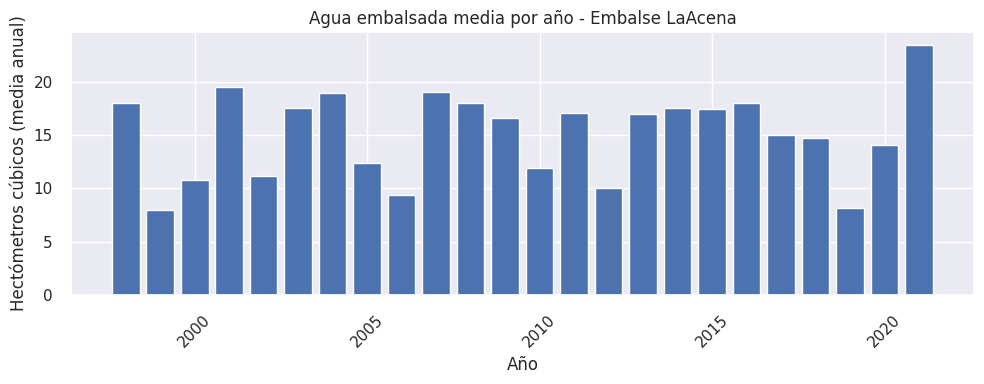

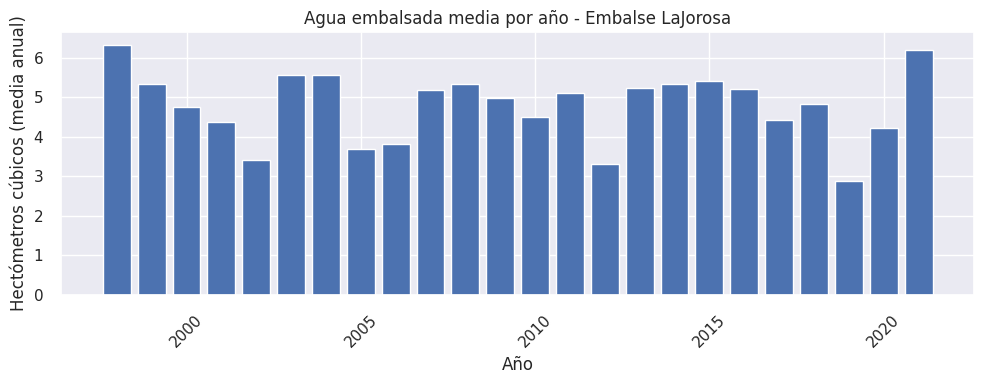

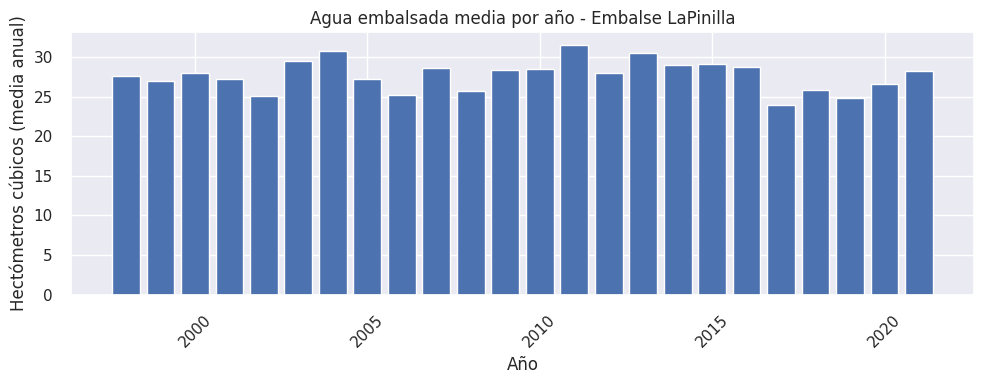

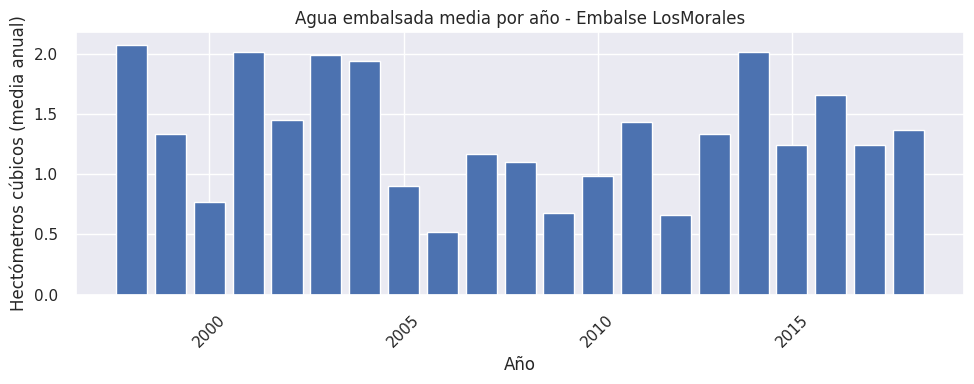

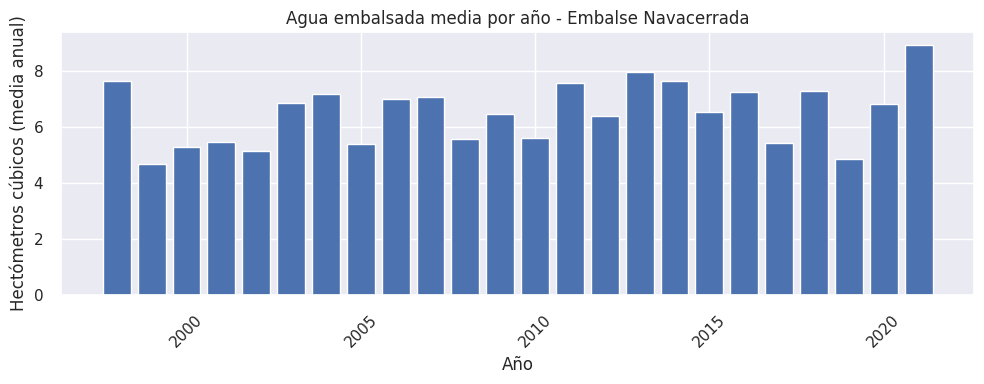

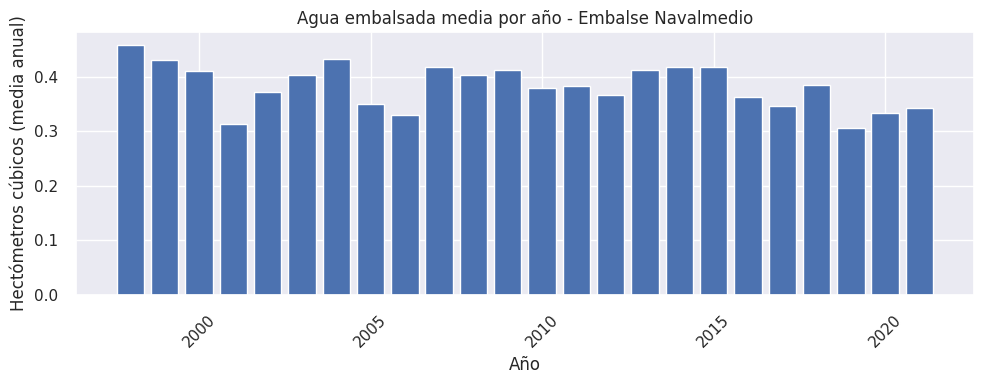

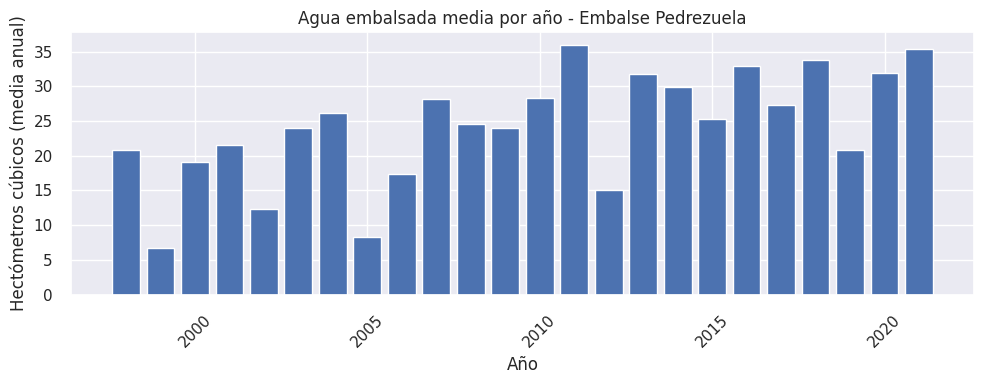

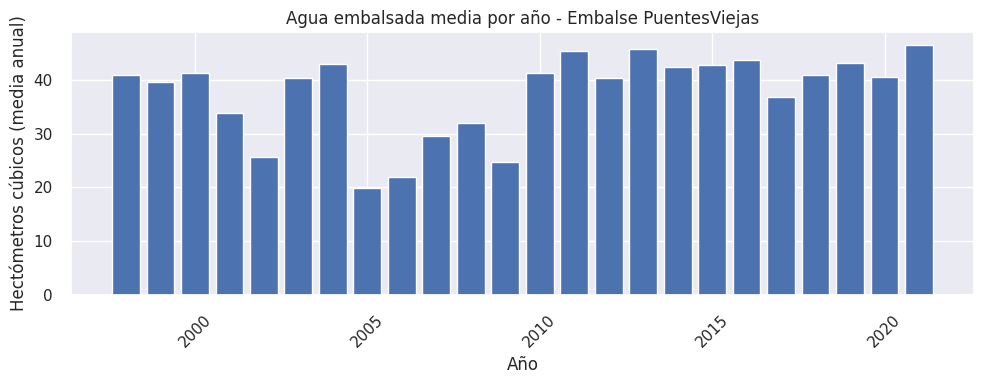

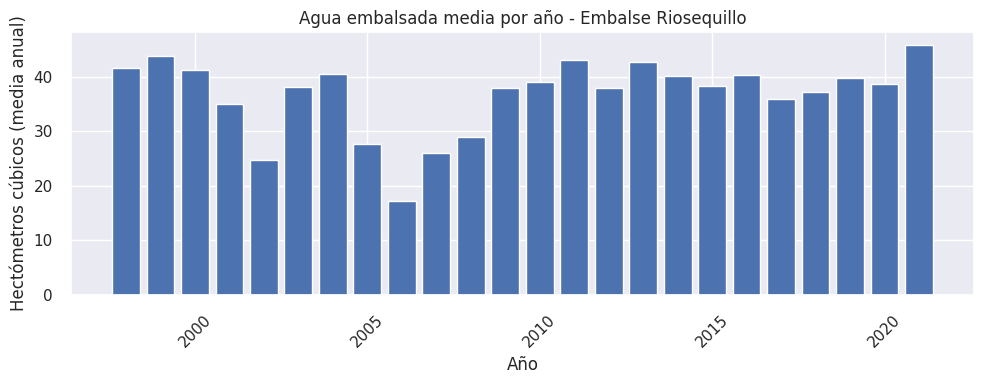

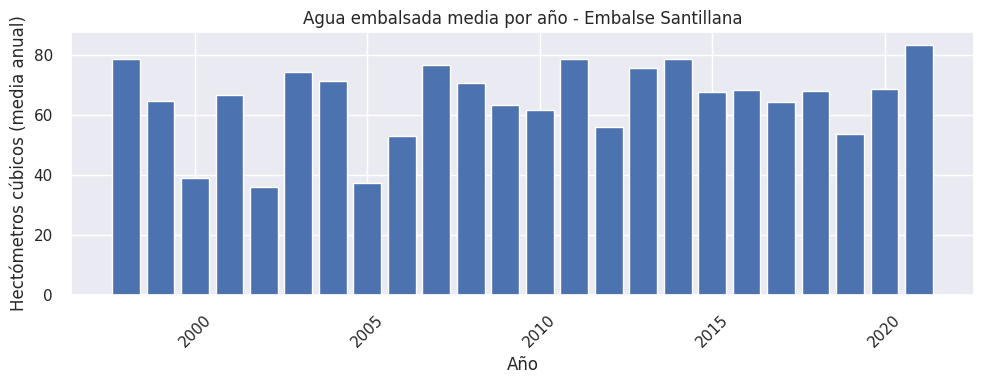

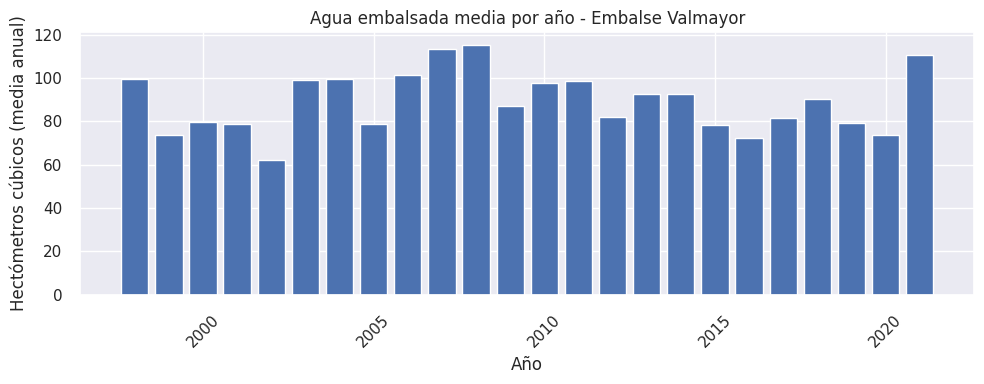

In [ ]:
def plot_barras_embalse(nombre_embalse: str):
    """
    Dibuja un gráfico de barras con la media anual de agua embalsada
    para un embalse concreto.
    """
    df_e = df_completo[df_completo["embalse"] == nombre_embalse]

    df_anual = (
        df_e.groupby("anio")["hec_cub"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(10, 4))
    plt.bar(df_anual["anio"].astype(int), df_anual["hec_cub"])
    plt.title(f"Agua embalsada media por año - Embalse {nombre_embalse}")
    plt.xlabel("Año")
    plt.ylabel("Hectómetros cúbicos (media anual)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



# generamos automáticamente un gráfico para cada embalse
for emb in sorted(df_completo["embalse"].unique()):
    plot_barras_embalse(emb)


## Gráfico de puntos (scatter) para comparar dos embalses

Requisito:
> "Gráfico de puntos para todos los años de dos embalses comparando estos."

En esta celda:
- Elegimos dos embalses.
- Filtramos `df_completo` para quedarnos solo con esos dos.
- Representamos cada punto como:
  - Eje X: fecha (mes-año).
  - Eje Y: volumen de agua (`hec_cub`).
- Usamos un color por embalse para comparar visualmente su comportamiento en el tiempo.


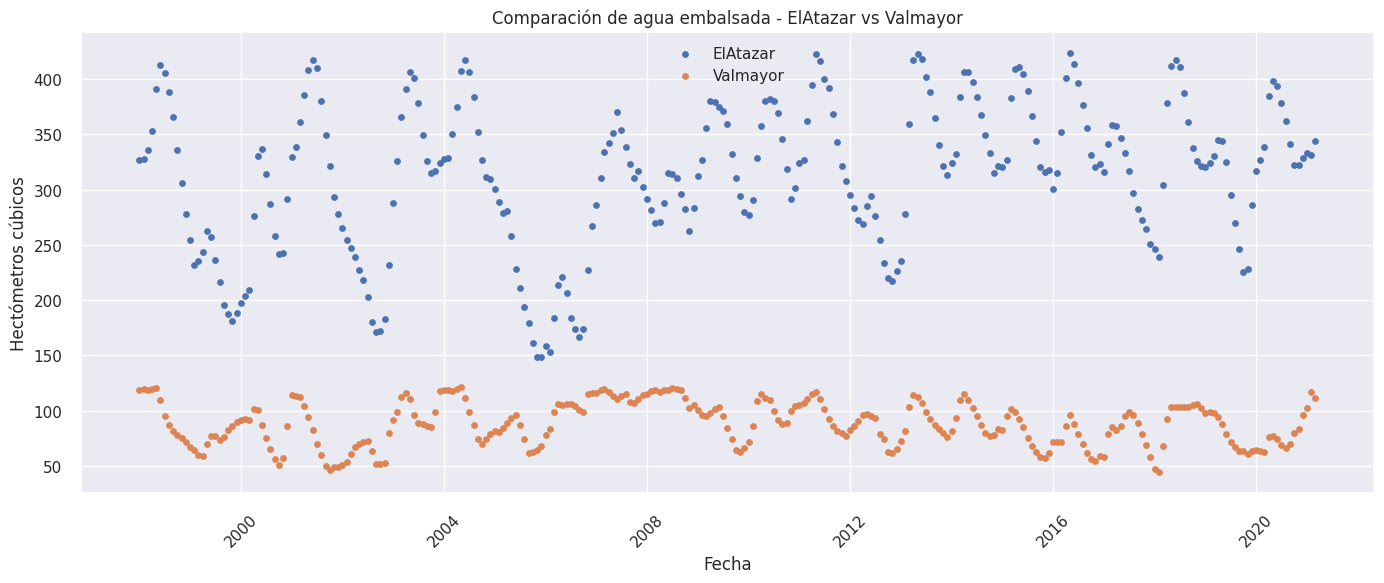

In [ ]:
def plot_scatter_dos_embalses(embalse_1: str, embalse_2: str):
    """
    Dibuja un gráfico de puntos comparando dos embalses a lo largo del tiempo.
    """
    seleccion = df_completo[df_completo["embalse"].isin([embalse_1, embalse_2])]

    plt.figure(figsize=(14, 6))

    for nombre, grupo in seleccion.groupby("embalse"):
        plt.scatter(
            grupo["fecha"],
            grupo["hec_cub"],
            s=15,           # tamaño del punto
            label=nombre    # nombre para la leyenda
        )

    plt.title(f"Comparación de agua embalsada - {embalse_1} vs {embalse_2}")
    plt.xlabel("Fecha")
    plt.ylabel("Hectómetros cúbicos")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso con dos embalses
plot_scatter_dos_embalses("ElAtazar", "Valmayor")


## Violin Plot por año: distribución de agua embalsada

Requisito:
> "Violin Plot: Mostrando por año la cantidad de agua embalsada."

El violin plot muestra la **distribución** (forma) de los datos:
- En el eje X pondremos el `anio`.
- En el eje Y el volumen `hec_cub`.

Cada "violín" representa cómo se distribuyen los valores mensuales de agua
embalsada en todos los embalses durante ese año (mediana, cuartiles, densidad).

Pasos:
1. Asegurarnos de que `anio` es entero.
2. Usar `seaborn.violinplot` con `x=anio`, `y=hec_cub`.

El violin plot muestra, para cada año, la distribución de volúmenes de agua
mensuales en todos los embalses:
- Años con distribuciones más bajas → posibles años secos.
- Años con distribuciones altas → años más húmedos.

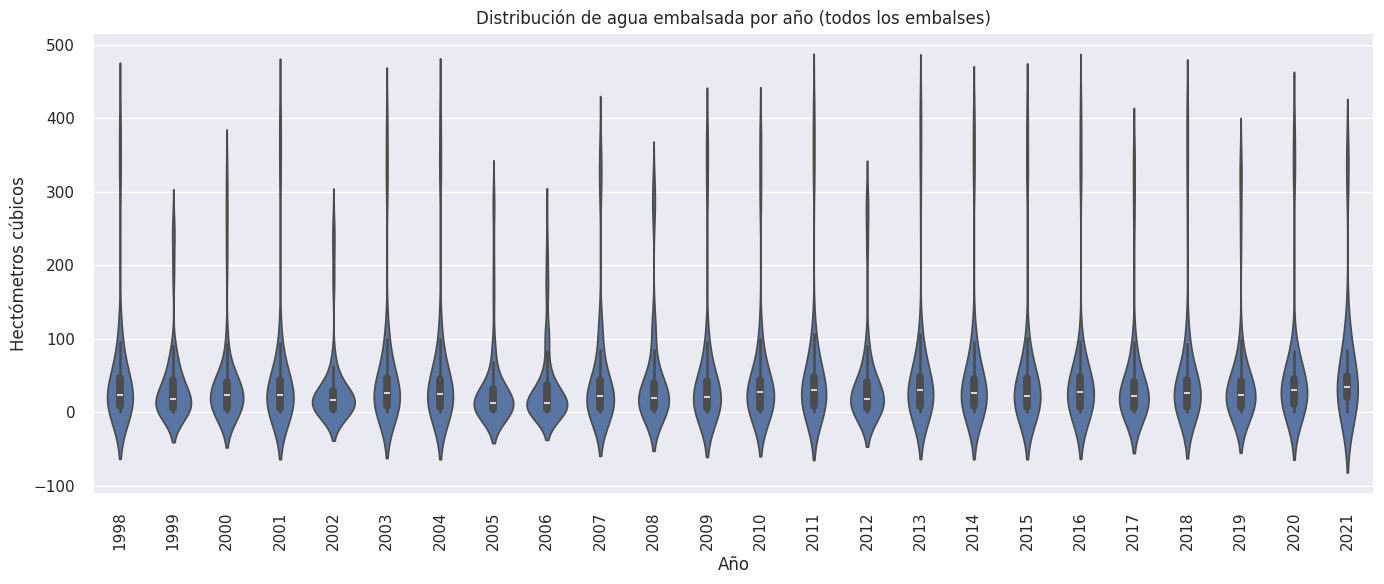

In [ ]:
# Convertimos 'anio' a entero para mejorar el eje X
df_completo["anio_int"] = df_completo["anio"].astype(int)

plt.figure(figsize=(14, 6))
sns.violinplot(
    data=df_completo,
    x="anio_int",
    y="hec_cub"
)

plt.title("Distribución de agua embalsada por año (todos los embalses)")
plt.xlabel("Año")
plt.ylabel("Hectómetros cúbicos")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Predicción con Prophet de los próximos 12 meses



Decisiones de modelado (hay varias posibles, aquí elegimos una clara):
- Vamos a predecir el **volumen total de agua embalsada en todos los embalses** mes a mes.
- Para ello:
  1. Agrupamos `df_completo` por `fecha` sumando `hec_cub`.
  2. Prophet necesita dos columnas:
     - `ds`: fecha (datetime).
     - `y`: valor numérico a predecir (aquí, agua total embalsada).
  3. Entrenamos un modelo Prophet con los datos históricos.
  4. Creamos un dataframe con 12 meses futuros.
  5. Obtenemos la predicción y la representamos gráficamente.




In [ ]:
# Instalación
!pip install -q prophet

from prophet import Prophet


In [ ]:
# 1) Agregamos el volumen total de agua embalsada por mes (fecha)
df_mensual_total = (
    df_completo
    .groupby("fecha")["hec_cub"]
    .sum()
    .reset_index()
    .sort_values("fecha")
)

# 2) Prophet requiere columnas 'ds' (fecha) y 'y' (valor)
df_prophet = df_mensual_total.rename(columns={"fecha": "ds", "hec_cub": "y"})

df_prophet.head()


,ds,y
0,1998-01-01,790.725
1,1998-02-01,793.020
2,1998-03-01,788.262
3,1998-04-01,812.977
4,1998-05-01,866.371


In [ ]:
# 3) Creamos y entrenamos el modelo Prophet
modelo = Prophet()
modelo.fit(df_prophet)

# 4) Creamos un dataframe con los próximos 12 meses
future = modelo.make_future_dataframe(periods=12, freq="MS")  # 'MS' = month start (inicio de mes)

# 5) Obtenemos la predicción
forecast = modelo.predict(future)

# Mostramos las últimas filas, donde aparecen los meses futuros
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(14)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
277,2021-02-01,729.100622,595.772160,869.312087
278,2021-03-01,770.251935,644.012484,906.754483
279,2021-04-01,814.709161,669.399276,943.478598
280,2021-05-01,829.008276,691.945205,964.784071
281,2021-06-01,797.623927,659.198744,923.287622
282,2021-07-01,745.450691,603.064961,880.520333
283,2021-08-01,694.042368,550.230586,835.641580
284,2021-09-01,648.201691,509.956252,783.717761
285,2021-10-01,622.545675,483.655283,764.436177
286,2021-11-01,631.811667,491.500712,772.035186


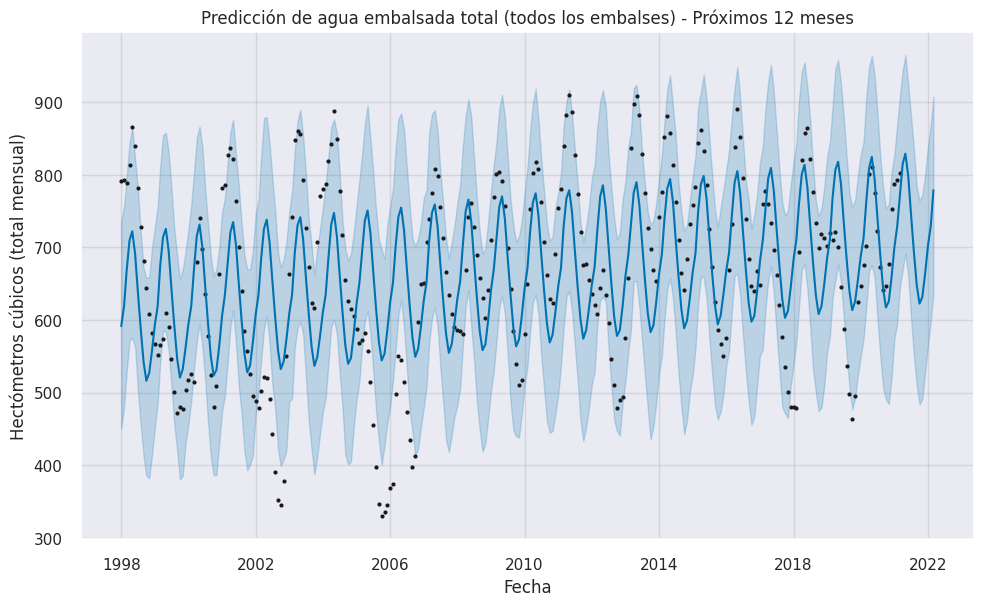

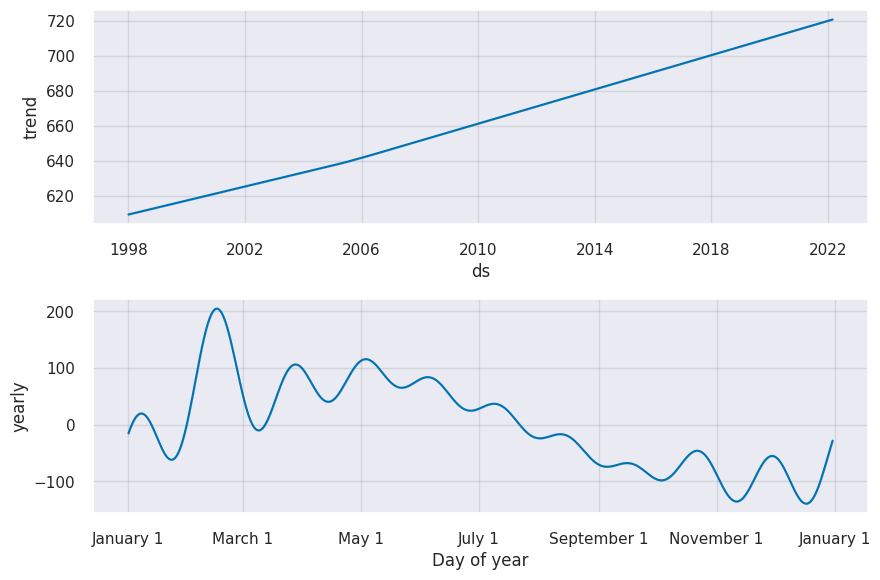

In [ ]:
# 6) Representamos la serie histórica + predicción
fig1 = modelo.plot(forecast)
plt.title("Predicción de agua embalsada total (todos los embalses) - Próximos 12 meses")
plt.xlabel("Fecha")
plt.ylabel("Hectómetros cúbicos (total mensual)")
plt.show()

# Opcional: componentes (tendencia, estacionalidad)
fig2 = modelo.plot_components(forecast)
plt.show()


## Evolución anual del volumen total del sistema de embalses

Para evaluar la sequía es importante observar si el **total de agua embalsada**
en todos los embalses muestra una tendencia descendente o se mantiene estable.

En esta celda:
- Agregamos el volumen total por año.
- Dibujamos un gráfico de línea del volumen anual total del sistema.


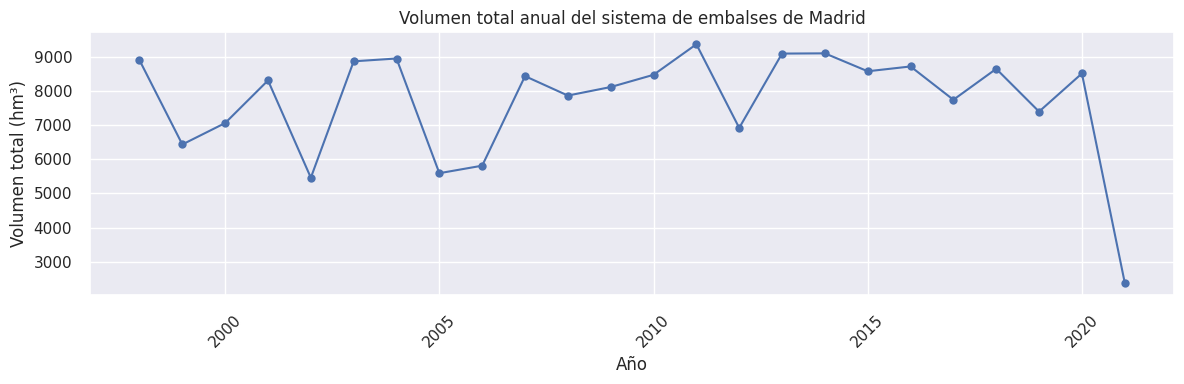

In [ ]:
df_total_anual = (
    df_completo
    .groupby("anio")["hec_cub"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(12, 4))
plt.plot(df_total_anual["anio"].astype(int), df_total_anual["hec_cub"], marker="o")
plt.title("Volumen total anual del sistema de embalses de Madrid")
plt.xlabel("Año")
plt.ylabel("Volumen total (hm³)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Cálculo del umbral de sequía del sistema (percentil 10)

Para poder afirmar si habrá sequía o no, definimos un **umbral de sequía**:

- Tomamos el **percentil 10 histórico** del volumen mensual total (`y` en `df_prophet`).
- Si la predicción `yhat` de Prophet cae por debajo de ese valor,
  consideramos que hay riesgo de sequía hidrológica.

Este umbral nos da un criterio objetivo y reproducible.


In [ ]:
umbral_sequia = df_prophet["y"].quantile(0.10)
print("Umbral de sequía (percentil 10 del volumen mensual total):", umbral_sequia)


Umbral de sequía (percentil 10 del volumen mensual total): 488.9936


## Detección automática de sequía en los próximos 12 meses

En esta celda comparamos la predicción (`yhat`) con el umbral de sequía:

- Si algún mes futuro tiene `yhat` < `umbral_sequia` → posible sequía.
- Si ningún mes cae por debajo → no se prevé sequía a corto plazo.

Mostramos explícitamente los meses con riesgo (si los hubiera).


In [ ]:
# Filtramos sólo los meses futuros (después de la última fecha histórica)
ultima_fecha_hist = df_prophet["ds"].max()
forecast_futuro = forecast[forecast["ds"] > ultima_fecha_hist]

forecast_sequia = forecast_futuro[forecast_futuro["yhat"] < umbral_sequia]

if forecast_sequia.empty:
    print("🔵 No se prevé sequía en los próximos 12 meses según el modelo y el umbral definido.")
else:
    print("🔴 Posible sequía detectada en los siguientes meses:")
    display(forecast_sequia[["ds", "yhat", "yhat_lower", "yhat_upper"]])


🔵 No se prevé sequía en los próximos 12 meses según el modelo y el umbral definido.


#  Conclusión final: ¿Habrá sequía en la comunidad de madrid en los siguientes años?

Tras realizar la ingesta, limpieza, transformación y análisis de los datos históricos de
los embalses de la Comunidad de Madrid, y tras aplicar el modelo de predicción Prophet,
podemos extraer las siguientes conclusiones:

### 1. Análisis histórico (EDA)
- Los gráficos de barras por año (globales e individuales) muestran variabilidad natural,
  con años más húmedos y otros más secos, pero sin colapsos extremos.
- Los violín plots por año muestran que la distribución de volúmenes mensuales se mantiene
  dentro de rangos razonables, sin indicadores de años con agua extremadamente baja de forma generalizada.
- Los gráficos por embalse confirman que, aunque hay diferencias entre ellos, ninguno presenta
  una caída drástica sostenida a lo largo de toda la serie.

### 2. Volumen total anual del sistema
- El gráfico del volumen total anual del sistema de embalses no muestra una tendencia
  claramente descendente.
- A pesar de las oscilaciones año a año, el total embalsado se mantiene en niveles
  comparables a los rangos históricos.

### 3. Definición del umbral de sequía
- Hemos definido un umbral de sequía basado en el **percentil 10 histórico** del volumen
  mensual total.
- Este umbral representa una “zona de riesgo” hidrológica: valores por debajo indican
  que el sistema está en una situación de agua embalsada significativamente baja respecto
  a su histórico.

### 4. Predicción con Prophet (12 meses)
- Prophet se ha entrenado con el histórico de volumen total mensual.
- La predicción de los próximos 12 meses (`yhat`) se mantiene dentro de los rangos
  habituales del sistema.
- Al comparar la predicción futura con el umbral de sequía:
  - **Ningún mes futuro cae por debajo del umbral definido.**
  - Por tanto, el modelo no anticipa caídas extremas del volumen total.

###  Conclusión para AEMET
Con los datos históricos disponibles y el modelo de predicción aplicado, **NO se prevé
una situación de sequía hidrológica generalizada en los próximos 12 meses** en la red
de embalses analizada. En consecuencia, **no parece necesario imponer medidas extraordinarias
de restricción de consumo de agua a corto plazo**, aunque sí se recomienda:

- Monitorización mensual continua.
- Actualización periódica del modelo con nuevos datos.
- Uso de un dashboard (por ejemplo, en Power BI) para supervisión en tiempo real.

Esta conclusión está basada en:
- El análisis exploratorio de los datos históricos.
- La agregación del volumen total del sistema.
- La definición objetiva de un umbral de sequía.
- Y la predicción de Prophet, que no muestra valores futuros por debajo de dicho umbral.


In [ ]:
import os

# carpeta donde están los CSV originales
print("Carpeta base:", base_folder)

output_path = os.path.join(base_folder, "datos_embalses_limpios.csv")

# Guardamos el dataframe completo en esa ruta
df_completo.to_csv(output_path, index=False)

print("✅ Archivo guardado en:", output_path)

# Comprobamos que realmente está en la carpeta
print("\nContenido de la carpeta base:")
print(os.listdir(base_folder))


Carpeta base: /content/embalses
✅ Archivo guardado en: /content/embalses/datos_embalses_limpios.csv

Contenido de la carpeta base:
['AguaEmbalsada_RioLozoya_Riosequillo.csv', 'AguaEmbalsada_RioLozoya_LaPinilla.csv', 'AguaEmbalsada_RioGuadalix_Pedrezuela.csv', 'datos_embalses_limpios.csv', 'AguaEmbalsada_RioLozoya_PuentesViejas.csv', 'AguaEmbalsada_RioManzanares_Navacerrada.csv', 'AguaEmbalsada_RioGuadarrama-Aulencia_Navalmedio.csv', 'AguaEmbalsada_RioLozoya_ElVillar.csv', 'AguaEmbalsada_RioCofio_LaAcena.csv', 'AguaEmbalsada_RioGuadarrama-Aulencia_LaJorosa.csv', 'AguaEmbalsada_RioGuadarrama-Aulencia_Valmayor.csv', 'AguaEmbalsada_RioLosMorales_LosMorales.csv', 'AguaEmbalsada_RioJarama_ElVado.csv', 'AguaEmbalsada_RioLozoya_ElAtazar.csv', 'AguaEmbalsada_RioManzanares_Santillana.csv']
